In [2]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [3]:
# businesses
bus = pd.read_csv('data/businesses.csv', encoding='ISO-8859-1')

date_format = '%Y%m%d'

def parse_dates_and_years(df, column='date'):
    dates = pd.to_datetime(df[column], format=date_format)
    years = dates.dt.year
    return df.assign(timestamp=dates, year=years)

# inspections
insp = (pd.read_csv("data/inspections.csv")
        .pipe(parse_dates_and_years))

# violations
viol = (pd.read_csv("data/violations.csv")
        .pipe(parse_dates_and_years))

In [4]:
def jitter(data, amt=0.2):
    return data + amt * (np.random.rand(len(data)) - 0.5)

(ch:wrangling_restaurants)=
# Example: Wrangling Restaurant Safety Violations

We wrap up this chapter with an example that demonstrates many data wrangling techniques. 
Recall from {numref}`Chapter %s <ch:files>` that the San Francisco restaurant inspection data are 
stored in three tables: `bus` (for businesses/restaurants), `insp` (for inspections), and `viol` (for safety violations). The violations dataset contains detailed descriptions of violations found during an inspection. We would like to capture some of this information and connect it to the inspection score, which is in inspection-level dataset. 

Our goal is to figure out the kinds of safety violations are associated with lower restaurant
safety scores. This example covers several key ideas in data wrangling related to changing structure:
+ filtering to focus on a narrower segment of data
+ aggregation to modify the granularity of a table
+ joining to bring together information across tables

Additionally, an important part of this example demonstrates how we transform text data into numeric quantities for analysis.

As a first step, let's simplify the structure by reducing the data to inspections from one year. (Recall that this dataset contains four years of inspection information.)  Below we tally the number of records for each year in the inspections table:

In [15]:
pd.value_counts(insp['year'])

year
2016    5443
2017    5166
2015    3305
2018     308
Name: count, dtype: int64

Reducing the data to cover one year of inspections will simplify our analysis. Later, if we want, we can return to carry out an analysis with all four years of data.

## Narrowing the Focus

We restrict our data wrangling to inspections that took place in 2016. Here, we can use the pipe function again in order to apply the same reshaping to both the inspections and violations data frames:

In [5]:
def subset_2016(df):
    return df.query('year == 2016')

vio2016 = viol.pipe(subset_2016)
ins2016 = insp.pipe(subset_2016)

In [6]:
ins2016.head(5)

,business_id,score,date,type,timestamp,year
0,19,94,20160513,routine,2016-05-13,2016
3,24,98,20161005,routine,2016-10-05,2016
4,24,96,20160311,routine,2016-03-11,2016
6,45,78,20160104,routine,2016-01-04,2016
9,45,84,20160614,routine,2016-06-14,2016


In {numref}`Chapter %s <ch:files>` we found that `business_id` and `timestamp` together uniquely identify the inspections (with a couple of exceptions). We also see here that restaurants can receive multiple inspections in a year---business \#24 had two inspections in 2016, one in March and another in October. 

Next, let's look at a few records from the violations table:

In [18]:
vio2016.head(5)

,business_id,date,description,timestamp,year
2,19,20160513,Unapproved or unmaintained equipment or utensi...,2016-05-13,2016
3,19,20160513,Unclean or degraded floors walls or ceilings ...,2016-05-13,2016
4,19,20160513,Food safety certificate or food handler card n...,2016-05-13,2016
6,24,20161005,Unclean or degraded floors walls or ceilings ...,2016-10-05,2016
7,24,20160311,Unclean or degraded floors walls or ceilings ...,2016-03-11,2016


Notice that the first few records are all for the same restaurant. If we want to bring violation information into the inspections table, we need to address the different granularities of these tables.  One approach is to aggregate the violations in some way. We discuss this next. 

## Aggregating Violations 

One simple aggregation of the violations is to count them and add that count to the inspections data table. To find the number of violations at an inspection, we can group the violations by `business_id` and `timestamp`, and then find the size of each group. Essentially, this grouping changes the granularity of violations to an inspection level:

In [7]:
num_vios = (vio2016
            .groupby(['business_id', 'timestamp'])
            .size()
            .reset_index()
            .rename(columns={0: 'num_vio'}));
num_vios.head(3)

,business_id,timestamp,num_vio
0,19,2016-05-13,3
1,24,2016-03-11,2
2,24,2016-10-05,1


Now we need to merge this new information with `ins2016`. Specifically, we want to *left join* `ins2016` with `num_vios` because there could be inspections that do not have any violations and we don't want to lose them:

In [8]:
def left_join_vios(ins):
    return ins.merge(num_vios, on=['business_id', 'timestamp'], how='left')

ins_and_num_vios = ins2016.pipe(left_join_vios)
ins_and_num_vios

,business_id,score,date,type,timestamp,year,num_vio
0,19,94,20160513,routine,2016-05-13,2016,3.0
1,24,98,20161005,routine,2016-10-05,2016,1.0
2,24,96,20160311,routine,2016-03-11,2016,2.0
...,...,...,...,...,...,...,...
5440,90096,91,20161229,routine,2016-12-29,2016,2.0
5441,90268,100,20161229,routine,2016-12-29,2016,NaN
5442,90269,100,20161229,routine,2016-12-29,2016,NaN


When there are no violations at an inspection, the feature `num_vio` has
a missing value (`NaN`). We can check how many values are missing:

In [9]:
ins_and_num_vios['num_vio'].isnull().sum()

833

About 15% of restaurant inspections in 2016 had no safety violations recorded. We can correct these missing values by setting them to 0 if the restaurant had a perfect safety score of 100. This is an example of deductive imputation since we're using domain knowledge to fill in missing values:

In [10]:
def zero_vios_for_perfect_scores(df):
    df = df.copy()
    df.loc[df['score'] == 100, 'num_vio'] = 0
    return df

ins_and_num_vios = (ins2016.pipe(left_join_vios)
                    .pipe(zero_vios_for_perfect_scores))

We can count the number of inspections with missing violation counts again:

In [11]:
ins_and_num_vios['num_vio'].isnull().sum()

65

We have corrected a large number of missing values. With further investigation,
we find that some of the businesses have inspection dates that are close but don't quite match. 
We could do a fuzzy match where inspections with dates that are only one or two days apart are matched. 
But for now, we just leave them as `NaN`. 

Let's examine the relationship between the number of violations and the inspection score:

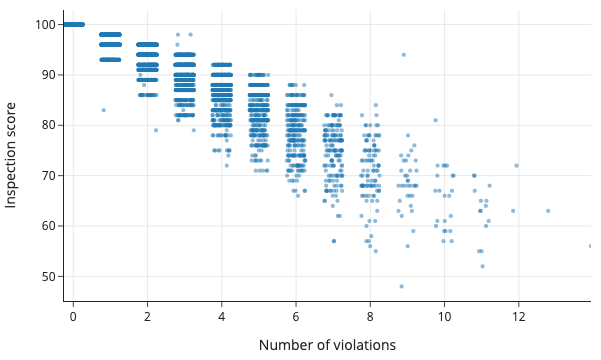

In [16]:
fig = px.strip(ins_and_num_vios,
                 x=jitter(ins_and_num_vios['num_vio'], amt=0.5),
                 y='score', 
                 width=400, height=250)

fig.update_traces(marker=dict(opacity=0.5, size=4))

fig.update_layout(xaxis_title="Number of violations",
                  yaxis_title="Inspection score")

fig

As we might expect there is a negative relationship between the inspection score and the number of violations. We can also see variability in score. The variability in scores grows with the number of violations. It appears that some violations are more serious than others and have a greater impact on the score. We extract information about the kinds of violations next.

## Extracting Information from Violation Descriptions

We saw earlier that the feature description in the violations data frame has a lot of text, including information in square brackets about when the violation was corrected. We can tally the descriptions and examine the most common violations:

In [17]:
display_df(vio2016['description'].value_counts().head(15).to_frame(), rows=15)

,description
Unclean or degraded floors walls or ceilings,161
Unapproved or unmaintained equipment or utensils,99
Moderate risk food holding temperature,95
Inadequate and inaccessible handwashing facilities,93
Inadequately cleaned or sanitized food contact surfaces,92
Improper food storage,81
Wiping cloths not clean or properly stored or inadequate sanitizer,71
Food safety certificate or food handler card not available,64
Moderate risk vermin infestation,58
Foods not protected from contamination,56


Reading through these wordy descriptions, we see that some are related to the cleanliness of facilities, others to the food storage, and still others pertain to the cleanliness of the staff.

Since there are many types of violations, we can try to group them together into larger categories. One way to do this is to create a simple boolean flag depending on whether the text contains a special word, like "vermin" or "hand" or "high risk".

With this approach, we create eight new features for different categories of violations. Don't
worry about the particular details of the code for now---this code uses
regular expressions, covered later in {numref}`Chapter %s <ch:text>`. The important
idea is that this code creates features containing `True` or `False` based on
whether the violation description contains specific words:

In [18]:
def make_vio_categories(vio):
    def has(term):
        return vio['description'].str.contains(term)

    return vio[['business_id', 'timestamp']].assign(
        high_risk        = has(r"high risk"),
        clean            = has(r"clean|sanit"),
        food_surface     = (has(r"surface") & has(r"\Wfood")),
        vermin           = has(r"vermin"),
        storage          = has(r"thaw|cool|therm|storage"),
        permit           = has(r"certif|permit"),
        non_food_surface = has(r"wall|ceiling|floor|surface"),
        human            = has(r"hand|glove|hair|nail"),
    )

In [19]:
vio_ctg = vio2016.pipe(make_vio_categories)
vio_ctg

,business_id,timestamp,high_risk,clean,...,storage,permit,non_food_surface,human
2,19,2016-05-13,False,False,...,False,False,False,False
3,19,2016-05-13,False,True,...,False,False,True,False
4,19,2016-05-13,False,False,...,False,True,False,True
...,...,...,...,...,...,...,...,...,...
38147,89900,2016-12-06,False,False,...,False,False,False,False
38220,90096,2016-12-29,False,False,...,False,False,False,False
38221,90096,2016-12-29,False,True,...,False,False,True,False


Now that we have these new features in `vio_ctg`, we can find out whether
certain violation categories are more impactful than others. For example,
are restaurant scores impacted more for vermin-related violations than
permit-relation violations?

To do this, we want to first count up the violations per business. Then, we can merge this information with the inspection information. First, let's sum the number of violations for each business:

In [20]:
vio_counts = vio_ctg.groupby(['business_id', 'timestamp']).sum().reset_index()
vio_counts

,business_id,timestamp,high_risk,clean,...,storage,permit,non_food_surface,human
0,19,2016-05-13,0,1,...,0,1,1,1
1,24,2016-03-11,0,2,...,0,0,2,0
2,24,2016-10-05,0,1,...,0,0,1,0
...,...,...,...,...,...,...,...,...,...
4803,89790,2016-11-29,0,0,...,0,0,0,1
4804,89900,2016-12-06,0,0,...,0,0,0,0
4805,90096,2016-12-29,0,1,...,0,0,1,0


Once again, we use a left join to merge these new features into the
inspection-level data frame.
And, for the special case of a score of 100, we set all of the new features to `0`:

In [21]:
feature_names = ['high_risk', 'clean', 'food_surface', 'vermin',
                 'storage', 'permit', 'non_food_surface', 'human']
def left_join_features(ins):
    return (ins[['business_id', 'timestamp', 'score']]
            .merge(vio_counts, on=['business_id', 'timestamp'], how='left'))

def zero_features_for_perfect_scores(ins):
    ins = ins.copy()
    ins.loc[ins['score'] == 100, feature_names] = 0
    return ins

In [22]:
ins_and_vios = (ins2016.pipe(left_join_features)
                .pipe(zero_features_for_perfect_scores))
ins_and_vios.head(3)

,business_id,timestamp,score,high_risk,...,storage,permit,non_food_surface,human
0,19,2016-05-13,94,0.0,...,0.0,1.0,1.0,1.0
1,24,2016-10-05,98,0.0,...,0.0,0.0,1.0,0.0
2,24,2016-03-11,96,0.0,...,0.0,0.0,2.0,0.0


To see how each violation category relates to the score, we can make a
collection of boxplots that compares the score distributions with and without
each violation. Since our focus here is on the data's patterns, not the
visualization code, we hide the code here.

In [25]:
features = ins_and_vios.melt(id_vars=['business_id', 'timestamp', 'score'],
                             var_name='violation', value_name='num_vios')
features['vio'] = features['num_vios'] > 0
any_vio = {False:"No", True:"Yes"}
features['vio'] = features['vio'].map(any_vio)

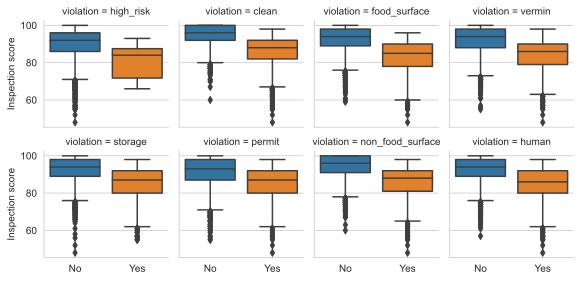

In [32]:
g = sns.catplot(data=features, x='vio', y='score',
            col='violation', col_wrap=4, kind='box', height=2)

g.set_axis_labels( "" , "Inspection score");

There are several interesting takeaways in these box plots.
As we'd expect, the more violations, the worse the restaurant score.
Restaurants that have no cleanliness-related violations
have the highest scores. Having a vermin violation isn't particularly worse
than other violations.
Rather, having a single high risk violation lowers the distribution of scores more than any
other violation. These observations are just the beginning of a possible
analysis into understanding what these scores mean.